In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # how to import text vectorization in tf 2.3.0
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
import gensim
from gensim.models import Word2Vec
from keras.models import Model
from tensorflow.keras.layers import Embedding,Input,Dropout, LSTM, Bidirectional, \
    Conv1D, MaxPool1D, Dense, Attention
from tensorflow.keras.models import Sequential

from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from keras.preprocessing.text import Tokenizer


import mlflow
plt.style.use('seaborn')

## Models hyperparamters version 1

* maximum length of the sequences - we will not use the actual maximum length of the sequences as very few songs have 800 words in them. If we choose a maximum length equal to 300, we will cover 94% of the lyrics' actual length, if we choose 250 - we will cover 90%. We can try with 300, if we have a problem with the vanishing gradient - we can decrease it to 250 or even 200 (85%)



* maximum vocabulary size (word-based vocabulary) -  The set of unique words used in the text corpus is ~ 50 000. Given the fact that we work with lyrics of songs, even though we selected only English lyrics there is a high probability that there are some words left from Spanish ( typical for pop songs), some typical slang for artists, and other peculiarities. Thus we will use the maximum size of vocabulary 10 000 ( if it is too big, we can drop it to 5000) and keep only the most common words.



* BATCH_SIZE = 16 
* MAX_VOCABULARY_SIZE = 10000 
* MAX_OUTPUT_LENGTH = 250 # 300
* EMBEDDING_DIMENSIONS = 100 #loaded GloVe trained  with 100d
* LEARNING_RATE = 1e-2


In [126]:
### Bookkeeping


TRAIN_BASE_DIR = r"C:\Users\PC\Desktop\NN\Text calssification\train"
TEST_BASE_DIR = r"C:\Users\PC\Desktop\NN\Text calssification\test"
logs = r"C:\Users\PC\Desktop\NN\Text calssification\logs"
check_point = r"C:\Users\PC\Desktop\NN\Text calssification\checkpoint"
check_point_opt = r"C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt"
check_point_bi = r"C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi"
N_CLASSES = 4

BATCH_SIZE = 16 # 8
MAX_VOCABULARY_SIZE = 10000 # change to 5000 if too big
MAX_OUTPUT_LENGTH = 250 # 300
EMBEDDING_DIMENSIONS = 100 #loaded GloVe trained  with 100d
LEARNING_RATE = 1e-2
Seed = 42

In [127]:

train_dataset = tf.keras.utils.text_dataset_from_directory(TRAIN_BASE_DIR,batch_size = BATCH_SIZE, validation_split=0.1,
    subset='training', seed = Seed)
   
   

Found 65048 files belonging to 4 classes.
Using 58544 files for training.


Found 65048 files belonging to 4 classes.
Using 58544 files for training.

In [128]:
print(train_dataset.cardinality().numpy())

3659


In [130]:
val_dataset = tf.keras.utils.text_dataset_from_directory(
    TRAIN_BASE_DIR, batch_size=BATCH_SIZE, validation_split=0.1,
    subset='validation', seed=Seed)

Found 65048 files belonging to 4 classes.
Using 6504 files for validation.


In [131]:
test_dataset = tf.keras.utils.text_dataset_from_directory(TEST_BASE_DIR,batch_size = BATCH_SIZE, seed = Seed)

Found 4000 files belonging to 4 classes.


In [132]:
### check the labesl
list(enumerate(train_dataset.class_names)), list(enumerate(val_dataset.class_names))

([(0, 'Jazz'), (1, 'Metal'), (2, 'Pop'), (3, 'Rock')],
 [(0, 'Jazz'), (1, 'Metal'), (2, 'Pop'), (3, 'Rock')])

In [133]:
list(enumerate(train_dataset.class_names))[1]

(1, 'Metal')

## Vectorizing the text

This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one sample = one string) into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens).

In [135]:
vectorize_layer = TextVectorization(
    max_tokens = MAX_VOCABULARY_SIZE, 
    output_sequence_length=MAX_OUTPUT_LENGTH)

In [136]:
text_ds = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [137]:
### 76952 vocabulary size without limiting the vocabulary size to max size

In [138]:
#text_ds

In [139]:
vectorize_layer.vocabulary_size()

10000

In [140]:
## 1 is unkown

In [141]:
#vectorize_layer(["something nigga money where love queen king boy girl"])

In [142]:
### test
vectorize_layer.get_vocabulary()[4000:]


['rang',
 'liberate',
 'imitation',
 'harvest',
 'frail',
 'eminem',
 'ditch',
 'crucify',
 'carter',
 'carol',
 'canvas',
 'brief',
 'yelling',
 'village',
 'stunna',
 'slut',
 'rocker',
 'relation',
 'oooo',
 'moonlit',
 'max',
 'loco',
 'league',
 'kelly',
 'incomplete',
 'grinding',
 'donna',
 'diggin',
 'decline',
 'coulda',
 'argue',
 'tuck',
 'spiral',
 'raped',
 'poster',
 'pitter',
 'marie',
 'lucifer',
 'lettin',
 'howling',
 'gyal',
 'farmer',
 'crunk',
 'countin',
 'assume',
 'aisle',
 'actor',
 'yow',
 'western',
 'upstairs',
 'twerk',
 'tipsy',
 'tic',
 'suffocate',
 'stash',
 'stairway',
 'sideways',
 'ruler',
 'rooftop',
 'retreat',
 'permanent',
 'nurse',
 'jury',
 'fu',
 'finna',
 'dreamy',
 'declare',
 'daze',
 'collapse',
 'boyz',
 'asshole',
 'worldwide',
 'wage',
 'vibration',
 'sweetness',
 'strut',
 'snatch',
 'rail',
 'purse',
 'nameless',
 'mysterious',
 'melancholy',
 'meanwhile',
 'laura',
 'jo',
 'hustlin',
 'feature',
 'coin',
 'blondie',
 'beyonce',
 'rom

In [143]:
### test 
#output = vectorize_layer([["the cat sat on the mat"]])
#output.numpy()[0, :11]


In [144]:
# Here's a dict mapping words to their indices:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(voc)

10000

In [145]:
list(word_index.keys())[:20]

['',
 '[UNK]',
 'im',
 'love',
 'know',
 'dont',
 'like',
 'oh',
 'get',
 'got',
 'go',
 'one',
 'time',
 'youre',
 'never',
 'see',
 'let',
 'come',
 'cant',
 'baby']

In [146]:
tf.keras.backend.clear_session()

### Load Pretrained Glove Word Embedding

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.


GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.


The GloVe model is trained on the non-zero entries of a global word-word co-occurrence matrix, which tabulates how frequently words co-occur with one another in a given corpus. Populating this matrix requires a single pass through the entire corpus to collect the statistics. For large corpora, this pass can be computationally expensive, but it is a one-time up-front cost. Subsequent training iterations are much faster because the number of non-zero matrix entries is typically much smaller than the total number of words in the corpus.



In [147]:
vectorize_layer.vocabulary_size()

10000

In [148]:
path_glove = (r'C:\Users\PC\Desktop\NN\NN Project\glove\glove.6B.100d.txt')

In [149]:
embeddings_index = {}
f = open(path_glove,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [150]:
#embeddings_index

#### Creating a weight matrix for words in training docs

In [151]:
### note to self 

#index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens.
num_tokens = len(voc) + 2
embedding_dim = EMBEDDING_DIMENSIONS
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9679 words (321 misses)


In [152]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41711   , -0.10176   ,  0.058147  , ..., -0.29444   ,
        -0.039114  ,  0.39534   ],
       ...,
       [ 0.63734001, -0.086567  ,  0.61628997, ..., -0.22788   ,
        -0.13654999,  0.01734   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Base LSTM Model

In [159]:
tf.keras.backend.clear_session()
model_name = "base lstm model"
checkpointer = ModelCheckpoint(filepath =check_point,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [160]:
lstm_base_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  LSTM(64),
  Dense(N_CLASSES,activation = softmax)])

In [161]:
lstm_base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 250)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 250, 100)          1000200   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 1,042,700
Trainable params: 42,500
Non-trainable params: 1,000,200
_________________________________________________________________


In [162]:
lstm_base_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [163]:
lstm_history_base_model = lstm_base_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          callbacks=[checkpointer, early_stopping])

Epoch 1/10
3659/3659 [==============================] - ETA: 0s - loss: 1.2018 - acc: 0.4533

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 502s 137ms/step - loss: 1.2018 - acc: 0.4533 - val_loss: 1.1187 - val_acc: 0.5128
Epoch 2/10
3659/3659 [==============================] - ETA: 0s - loss: 1.0601 - acc: 0.5443

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 532s 145ms/step - loss: 1.0601 - acc: 0.5443 - val_loss: 1.0838 - val_acc: 0.5292
Epoch 3/10
3659/3659 [==============================] - ETA: 0s - loss: 1.0274 - acc: 0.5609

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 530s 145ms/step - loss: 1.0274 - acc: 0.5609 - val_loss: 1.0621 - val_acc: 0.5397
Epoch 4/10
3659/3659 [==============================] - ETA: 0s - loss: 1.0097 - acc: 0.5689

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 531s 145ms/step - loss: 1.0097 - acc: 0.5689 - val_loss: 1.0079 - val_acc: 0.5667
Epoch 5/10
3659/3659 [==============================] - ETA: 0s - loss: 0.9889 - acc: 0.5796

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 531s 145ms/step - loss: 0.9889 - acc: 0.5796 - val_loss: 1.0037 - val_acc: 0.5818
Epoch 6/10
3659/3659 [==============================] - ETA: 0s - loss: 0.9695 - acc: 0.5909

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 549s 150ms/step - loss: 0.9695 - acc: 0.5909 - val_loss: 0.9929 - val_acc: 0.5861
Epoch 7/10
3659/3659 [==============================] - ETA: 0s - loss: 0.9731 - acc: 0.5904

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 572s 156ms/step - loss: 0.9731 - acc: 0.5904 - val_loss: 0.9979 - val_acc: 0.5789
Epoch 8/10
3659/3659 [==============================] - ETA: 0s - loss: 0.9660 - acc: 0.5946

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 534s 146ms/step - loss: 0.9660 - acc: 0.5946 - val_loss: 0.9856 - val_acc: 0.5952
Epoch 9/10
3659/3659 [==============================] - ETA: 0s - loss: 1.0321 - acc: 0.5562

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 537s 147ms/step - loss: 1.0321 - acc: 0.5562 - val_loss: 1.1324 - val_acc: 0.5066
Epoch 10/10
3659/3659 [==============================] - ETA: 0s - loss: 1.0993 - acc: 0.5190

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint\assets


3659/3659 [==============================] - 538s 147ms/step - loss: 1.0993 - acc: 0.5190 - val_loss: 1.1137 - val_acc: 0.5171


In [164]:
def plot_loss_accuracy(hist,model):
    fig=plt.figure()
    plt.plot(hist.history['acc'],'r',linewidth=3.0)
    plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title(f'Accuracy Curves : {model}',fontsize=16)
    #fig.savefig('accuracy_lstm.png')
    plt.show()

In [181]:
lstm_base_version_1_hist = lstm_history_base_model

In [182]:
%store lstm_base_version_1_hist

INFO:tensorflow:Assets written to: ram://84ae2c97-f3c6-4d1a-a3b9-4d2e68ed29cf/assets


INFO:tensorflow:Assets written to: ram://84ae2c97-f3c6-4d1a-a3b9-4d2e68ed29cf/assets


Stored 'lstm_base_version_1_hist' (History)


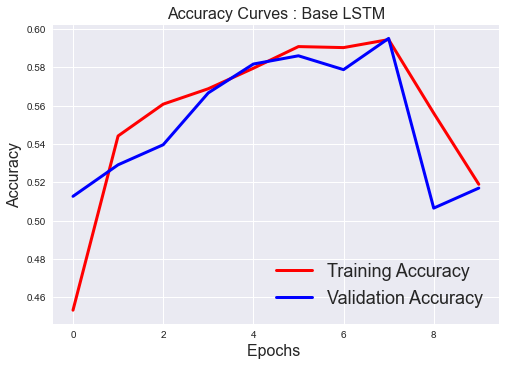

In [165]:
plot_loss_accuracy(lstm_history_base_model, 'Base LSTM')

In [173]:
_,val_acc = lstm_base_model.evaluate(val_dataset)

407/407 [==============================] - 29s 70ms/step - loss: 1.1137 - acc: 0.5171


In [172]:
base_lstm_ver_1 = pd.DataFrame(lstm_history_base_model.history)
base_lstm_ver_1['epoch'] = lstm_history_base_model.epoch

In [174]:
base_lstm_ver_1 

,loss,acc,val_loss,val_acc,epoch
0,1.201788,0.453334,1.118654,0.512761,0
1,1.060113,0.544257,1.083847,0.529213,1
2,1.027447,0.560860,1.062087,0.539668,2
3,1.009662,0.568905,1.007879,0.566728,3
4,0.988928,0.579598,1.003674,0.581796,4
5,0.969532,0.590906,0.992918,0.586101,5
6,0.973129,0.590376,0.997913,0.578875,6
7,0.966017,0.594561,0.985633,0.595172,7
8,1.032065,0.556180,1.132448,0.506611,8
9,1.099295,0.519028,1.113680,0.517066,9


In [175]:
lstm_base_model.predict([''' 
It seems you're having some trouble In dealing with these changes Living with these changes (oh no) 
The world is a scary place Now that you've woken up the demon in me 
Why can't you just leave here and die Never stick your hand in my face again bitch
Fuck you
I don't need this shit

''' ])


1/1 [==============================] - 0s 52ms/step


array([[0.17089583, 0.28224355, 0.1576072 , 0.38925344]], dtype=float32)

In [54]:
train_dataset.class_names

['Jazz', 'Metal', 'Pop', 'Rock']

## Optimize base LSTM

In [ ]:
tf.keras.backend.clear_session()

In [68]:
model_name = "optimized lstm model"
checkpointer_opt = ModelCheckpoint(filepath =check_point_opt,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_opt = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [69]:
lstm_opt_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  LSTM(128,return_sequences=True,dropout=0.2),
  tf.keras.layers.GlobalMaxPooling1D(),
  Dense(64,activation='relu'),
  Dense(N_CLASSES,activation = softmax)])

In [70]:
lstm_opt_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 250, 100)          1000200   
                                                                 
 lstm_4 (LSTM)               (None, 250, 128)          117248    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 4)                

In [71]:
lstm_opt_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [72]:
lstm_history_opt_model = lstm_opt_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 5,
          callbacks=[checkpointer_opt, early_stopping_opt])

Epoch 1/5
3659/3659 [==============================] - ETA: 0s - loss: 1.0307 - acc: 0.5523

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


3659/3659 [==============================] - 406s 110ms/step - loss: 1.0307 - acc: 0.5523 - val_loss: 0.9660 - val_acc: 0.5910
Epoch 2/5
3659/3659 [==============================] - ETA: 0s - loss: 0.9702 - acc: 0.5944

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


3659/3659 [==============================] - 382s 104ms/step - loss: 0.9702 - acc: 0.5944 - val_loss: 0.9544 - val_acc: 0.5959
Epoch 3/5
3659/3659 [==============================] - ETA: 0s - loss: 0.9508 - acc: 0.6040

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


3659/3659 [==============================] - 391s 107ms/step - loss: 0.9508 - acc: 0.6040 - val_loss: 0.9357 - val_acc: 0.6113
Epoch 4/5
3659/3659 [==============================] - ETA: 0s - loss: 0.9468 - acc: 0.6061

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


3659/3659 [==============================] - 436s 119ms/step - loss: 0.9468 - acc: 0.6061 - val_loss: 0.9363 - val_acc: 0.6087
Epoch 5/5
3659/3659 [==============================] - ETA: 0s - loss: 0.9401 - acc: 0.6089

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_opt\assets


3659/3659 [==============================] - 478s 131ms/step - loss: 0.9401 - acc: 0.6089 - val_loss: 0.9387 - val_acc: 0.6107


In [81]:
tf.keras.backend.clear_session()

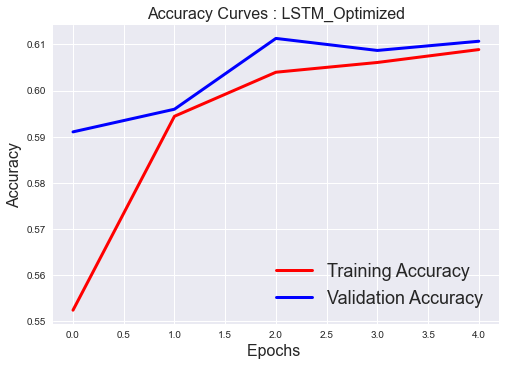

In [77]:
plot_loss_accuracy(lstm_history_opt_model, 'LSTM_Optimized')

In [176]:
_,val_acc = lstm_opt_model.evaluate(val_dataset)

407/407 [==============================] - 69s 168ms/step - loss: 0.9387 - acc: 0.6107


In [177]:
opt_lstm_ver_1 = pd.DataFrame(lstm_history_opt_model.history)
opt_lstm_ver_1['epoch'] = lstm_history_opt_model.epoch

In [178]:
opt_lstm_ver_1

,loss,acc,val_loss,val_acc,epoch
0,1.030676,0.552303,0.965992,0.591021,0
1,0.970219,0.594408,0.954409,0.595941,1
2,0.950770,0.603973,0.935729,0.611316,2
3,0.946829,0.606091,0.936261,0.608702,3
4,0.940131,0.608892,0.938706,0.610701,4


## Multi - layer BiDirectional LSTM

In [87]:
model_name = "bidirectional lstm model"
checkpointer_bi = ModelCheckpoint(filepath =check_point_bi,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_bi = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [84]:
lstm_bi_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Bidirectional(LSTM(64, return_sequences = True)),
  Bidirectional(LSTM(64)),
  Dense(N_CLASSES, activation = softmax)
  ])

In [85]:
lstm_bi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 100)          1000200   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                        

In [86]:
lstm_bi_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [88]:
lstm_history_bi_model = lstm_bi_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 5,
          callbacks=[checkpointer_bi, early_stopping_bi])

Epoch 1/5
3659/3659 [==============================] - ETA: 0s - loss: 1.0678 - acc: 0.5320

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


3659/3659 [==============================] - 651s 176ms/step - loss: 1.0678 - acc: 0.5320 - val_loss: 0.9933 - val_acc: 0.5693
Epoch 2/5
3659/3659 [==============================] - ETA: 0s - loss: 0.9576 - acc: 0.5936

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


3659/3659 [==============================] - 610s 167ms/step - loss: 0.9576 - acc: 0.5936 - val_loss: 0.9811 - val_acc: 0.5950
Epoch 3/5
3659/3659 [==============================] - ETA: 0s - loss: 0.9286 - acc: 0.6055

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


3659/3659 [==============================] - 703s 192ms/step - loss: 0.9286 - acc: 0.6055 - val_loss: 0.9599 - val_acc: 0.6002
Epoch 4/5
3659/3659 [==============================] - ETA: 0s - loss: 0.8983 - acc: 0.6219

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


3659/3659 [==============================] - 1445s 395ms/step - loss: 0.8983 - acc: 0.6219 - val_loss: 0.9457 - val_acc: 0.6070
Epoch 5/5
3659/3659 [==============================] - ETA: 0s - loss: 0.9026 - acc: 0.6203

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\checkpoint_bi\assets


3659/3659 [==============================] - 1831s 500ms/step - loss: 0.9026 - acc: 0.6203 - val_loss: 0.9394 - val_acc: 0.6090


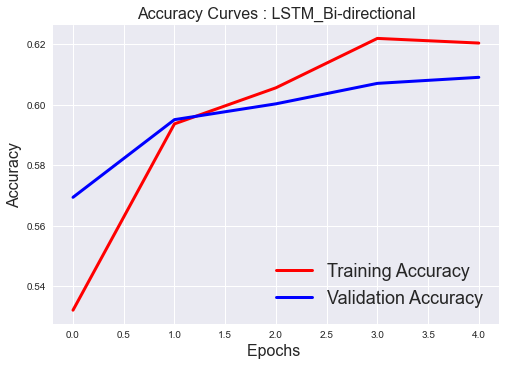

In [167]:
plot_loss_accuracy(lstm_history_bi_model, 'LSTM_Bi-directional')

In [169]:
_,val_acc = lstm_bi_model.evaluate(val_dataset)

407/407 [==============================] - 124s 303ms/step - loss: 0.9394 - acc: 0.6090


change the batch to 128 -> with 16 is really slow

In [179]:
lstm_bidirectional_ver_1 = pd.DataFrame(lstm_history_bi_model.history)
lstm_bidirectional_ver_1['epoch'] = lstm_history_bi_model.epoch

In [180]:
lstm_bidirectional_ver_1

,loss,acc,val_loss,val_acc,epoch
0,1.067775,0.532027,0.993251,0.569342,0
1,0.957569,0.593622,0.981090,0.595018,1
2,0.928630,0.605545,0.959893,0.600246,2
3,0.898315,0.621874,0.945742,0.607011,3
4,0.902642,0.620337,0.939404,0.609010,4
